In [1]:
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["target"] = data.target

# Select a fixed set of 5 features
selected_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension']

# Duplicate one of the selected features to introduce 100% correlation
duplicated_feature = 'mean concave points'
df[f"{duplicated_feature}_dup"] = df[duplicated_feature]

# Define features and target
features = selected_features + [f"{duplicated_feature}_dup"]
X = df[features]
y = df["target"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to train XGBoost and compute SHAP values and built-in feature importance
def train_xgb_and_compute_importance(colsample_bytree):
    model = xgb.XGBClassifier(
        colsample_bytree=colsample_bytree,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # SHAP explainer
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)
    
    # Compute mean absolute SHAP values per feature
    mean_shap_values = np.abs(shap_values.values).mean(axis=0)
    
    # Get XGBoost's built-in feature importance (Gain-based importance)
    feature_importance_gain = model.get_booster().get_score(importance_type="gain") #total_gain

    return shap_values, mean_shap_values, feature_importance_gain

# Train models with different colsample_bytree values
colsample_values = [1, 0.9, 0.8,0.7,0.6,0.5,0.3]
shap_results = {}
mean_shap_importance = {}
xgb_feature_importance = {}

for colsample in colsample_values:
    shap_values, mean_shap, feature_importance = train_xgb_and_compute_importance(colsample)
    shap_results[colsample] = shap_values
    mean_shap_importance[colsample] = mean_shap
    xgb_feature_importance[colsample] = feature_importance

# Convert SHAP feature importance to DataFrame for comparison
shap_importance_df = pd.DataFrame(mean_shap_importance, index=features)

# Convert XGBoost built-in feature importance to DataFrame
xgb_importance_df = pd.DataFrame.from_dict(xgb_feature_importance, orient="index").T.fillna(0)



e:\Users\xwang\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:03:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
e:\Users\xwang\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:03:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
e:\Users\xwang\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:03:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
e:\Users\xwang\anaconda3\Lib\site-packages\

In [3]:
shap_importance_df

,1.0,0.9,0.8,0.7,0.6,0.5,0.3
mean radius,0.034502,0.007867,0.000000,0.020771,0.048963,0.052919,0.137079
mean texture,0.419982,0.497453,0.452617,0.663359,0.627993,0.648564,0.620752
mean perimeter,0.000000,0.021703,0.000000,0.019791,0.022430,0.073228,0.116640
mean area,0.303718,0.182681,0.284168,0.133987,0.324277,0.454561,0.127078
mean smoothness,0.321377,0.387727,0.296207,0.358711,0.359295,0.348783,0.335752
mean compactness,0.165571,0.151319,0.175695,0.198717,0.291798,0.173599,0.197848
mean concavity,0.228411,0.131031,0.059684,0.055921,0.084626,0.147873,0.142022
mean concave points,1.251806,1.324015,1.161262,1.169152,1.054479,0.668415,0.510825
mean symmetry,0.000000,0.026407,0.034260,0.033544,0.041545,0.053616,0.029227
mean fractal dimension,0.094030,0.099737,0.028911,0.068795,0.057798,0.066066,0.100884


In [5]:
xgb_importance_df

,1.0,0.9,0.7,0.6,0.5,0.3,0.8
mean radius,1.296896,0.001715,5.145724,4.275808,1.028204,2.120908,0.000000
mean texture,1.460249,1.471243,2.385813,2.226191,1.460102,1.690223,1.961353
mean area,1.248028,1.086928,1.209759,7.586008,5.324190,0.367412,1.181414
mean smoothness,0.469305,0.606139,0.271654,0.242358,0.543343,0.694731,0.424996
mean compactness,0.204228,0.301142,0.371546,0.347907,0.380164,0.353622,0.422566
mean concavity,0.740262,0.931171,0.533663,0.154264,0.045242,0.837377,0.601887
mean concave points,23.850195,27.689949,31.298992,27.976488,21.763048,3.050948,31.991697
mean fractal dimension,0.398110,1.647589,2.338000,2.700024,2.776071,2.068546,3.723879
radius error,0.535964,1.345915,1.390862,1.178962,1.711786,1.093988,1.109348
texture error,0.458119,0.089006,1.557524,0.000000,0.799962,2.885865,1.442149


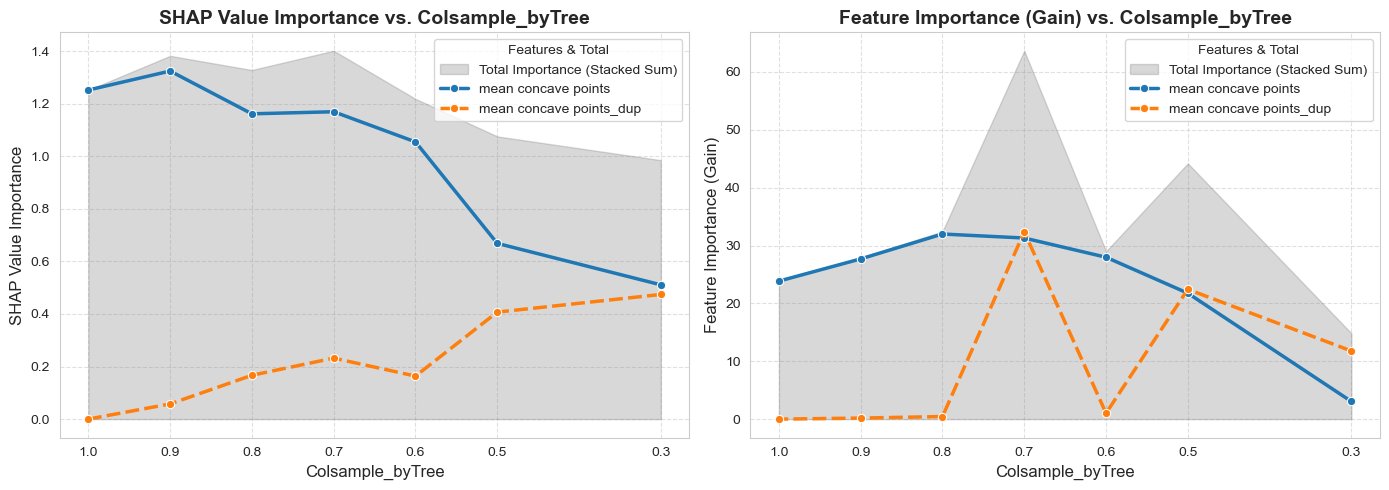

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Define the data manually
colsample_values = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.3]
feature_importance_shap = {
    "mean concave points": [1.251806, 1.324015, 1.161262, 1.169152, 1.054479, 0.668415, 0.510825],
    "mean concave points_dup": [0, 0.057759, 0.166642, 0.232023, 0.163661, 0.406946, 0.47417],
}
feature_importance_gain = {
    "mean concave points": [23.850195, 27.689949, 31.991697, 31.298992, 27.976488, 21.763048, 3.050948],
    "mean concave points_dup": [0, 0.177218, 0.444054, 32.36916, 1.021364, 22.43327, 11.777714],
}

# Create DataFrames
df_shap = pd.DataFrame(feature_importance_shap, index=colsample_values)
df_shap.index.name = "Colsample_byTree"
df_shap["Total Importance"] = df_shap["mean concave points"] + df_shap["mean concave points_dup"]

df_gain = pd.DataFrame(feature_importance_gain, index=colsample_values)
df_gain.index.name = "Colsample_byTree"
df_gain["Total Importance"] = df_gain["mean concave points"] + df_gain["mean concave points_dup"]

# Set style
sns.set_style("whitegrid")

# Create side-by-side figures
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SHAP Value Importance Plot
axes[0].fill_between(df_shap.index, df_shap["Total Importance"], color="gray", alpha=0.3, label="Total Importance (Stacked Sum)")
sns.lineplot(data=df_shap[["mean concave points", "mean concave points_dup"]], marker="o", linewidth=2.5, ax=axes[0])
axes[0].set_ylabel("SHAP Value Importance", fontsize=12)
axes[0].set_xlabel("Colsample_byTree", fontsize=12)
axes[0].set_xticks(colsample_values)
axes[0].invert_xaxis()
axes[0].set_title("SHAP Value Importance vs. Colsample_byTree", fontsize=14, fontweight="bold")
axes[0].legend(title="Features & Total", fontsize=10, loc="upper right")
axes[0].grid(True, linestyle="--", alpha=0.6)

# Feature Importance (Gain) Plot
axes[1].fill_between(df_gain.index, df_gain["Total Importance"], color="gray", alpha=0.3, label="Total Importance (Stacked Sum)")
sns.lineplot(data=df_gain[["mean concave points", "mean concave points_dup"]], marker="o", linewidth=2.5, ax=axes[1])
axes[1].set_ylabel("Feature Importance (Gain)", fontsize=12)
axes[1].set_xlabel("Colsample_byTree", fontsize=12)
axes[1].set_xticks(colsample_values)
axes[1].invert_xaxis()
axes[1].set_title("Feature Importance (Gain) vs. Colsample_byTree", fontsize=14, fontweight="bold")
axes[1].legend(title="Features & Total", fontsize=10, loc="upper right")
axes[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()
